<a href="https://colab.research.google.com/github/Kac1509/ZebrafishClassifier/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os

#Set if running locally or in Google Colaboratory
Colab = False
if Colab:
    Script_path = '/content/gdrive/My Drive/Colab Notebooks/Classifier/scripts'
    Base_path = '/content/gdrive/My Drive/Colab Notebooks/Classifier/'
    from google.colab import drive
    drive.mount('/content/gdrive')
else:
    Script_path = os.getcwd() + '/Classifier/scripts'
    Base_path = 'Classifier/'

#Add script folder to system path
sys.path.insert(0, Script_path)
print(sys.path)

['C:\\Users\\Kaleem\\EPFL\\Fall 2018\\Machine Learning\\Project_2\\Git\\ZebrafishClassifier/Classifier/scripts', '', 'C:\\Users\\Kaleem\\Anaconda3\\python36.zip', 'C:\\Users\\Kaleem\\Anaconda3\\DLLs', 'C:\\Users\\Kaleem\\Anaconda3\\lib', 'C:\\Users\\Kaleem\\Anaconda3', 'C:\\Users\\Kaleem\\AppData\\Roaming\\Python\\Python36\\site-packages', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\Sphinx-1.5.6-py3.6.egg', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\setuptools-27.2.0-py3.6.egg', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Kaleem\\AppData\\Roaming\\SPB_Data\\.ipython']


In [2]:
%load_ext autoreload
%autoreload 2
from load_pre_trained_VGG16 import *
from load_pre_trained_Inception import *
from build_model_RMSprop import *
from unzip_data import *
from create_data_generators import *
from model_prediction import *
from createFolders import *
from createSets import *
from saveFiles import *
from plot_loss_acc import *
from predictClass import *




C:\Users\Kaleem\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#Name of the data zipfile
Data_file = 'DataStraightened.zip'

#Set Paths
Zip_path = Base_path + Data_file
Extracted_path = Base_path + 'ExtractedData/'
Partitioned_path = Base_path + 'PartitionedData/'
Prediction_path = Base_path + 'Predictions/'


In [ ]:
#Specify input parameters for the pre_trained model

shapeY = 50
shapeX = 150
color_channels = 3

# Loading pre-trained models

#VGG16 Model
local_weights_file_VGG16 = Base_path + 'weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model_VGG16, last_layer_output_VGG16 = load_pre_trained_VGG16(local_weights_file_VGG16, shapeY, shapeX, color_channels)

# Inception Model
local_weights_file_Inception = Base_path + 'weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model_Inception, last_layer_output_Inception = load_pre_trained_Inception(local_weights_file_Inception, shapeY, shapeX, color_channels)


In [5]:
#Clear Folders and create Prediction folder

deleteFiles(Extracted_path)
deleteFiles(Partitioned_path)
createFolder(Prediction_path)


In [7]:
#Extract Data

unzip_data(Zip_path, Extracted_path)

In [8]:
#Create Genotype classes

Genotypes = []
num_classes = len(glob.glob(Extracted_path+'*'))
for i in range(num_classes):
        #Retrieve directory for a given type
        Genotype_name = os.listdir(Extracted_path)[i]
        Genotypes.append(Genotype(Genotype_name))
print(num_classes)
createDirectories(num_classes,Extracted_path,Partitioned_path,Genotypes)


3


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1359x150 at 0x13180159320>


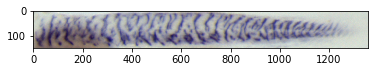

In [9]:
#Sample Image 

print(Genotypes[1].images[0])
plt.imshow(Genotypes[1].images[0])

In [10]:
#Partition data into training and test set
#If fixed set to true, all training and test sets have the same size for all classes 

createTrain_Test(Genotypes,0.5, fixed = True)

31
76
33


In [11]:
#Save partitions to respective folders

saveFiles(Genotypes)

In [12]:
# Creating training and validation data generators from separated data
# Transformations are for training generator only

train_generator, validation_generator = create_data_generators(
    Partitioned_path,
    shapeY, shapeX, 
    train_batch_size=12, 
    validation_batch_size=15,
    class_mode='categorical')#,
    #rotation_range=30,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    #shear_range=0.3,
    #zoom_range=0.3)

Found 48 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


In [15]:
# Building model

model = build_model_RMSprop(pre_trained_model_VGG16, last_layer_output_VGG16, 
                            learning_rate = 0.00001, hidden_units_num = 1024,num_classes=num_classes,activation = 'softmax')

In [14]:
# Training model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=4,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=3,
      verbose=2)

Epoch 1/10
 - 11s - loss: 0.7439 - acc: 0.5625 - val_loss: 0.6839 - val_acc: 0.5926
Epoch 2/10
 - 11s - loss: 0.6823 - acc: 0.5556 - val_loss: 0.6503 - val_acc: 0.5852
Epoch 3/10
 - 12s - loss: 0.6458 - acc: 0.5972 - val_loss: 0.6248 - val_acc: 0.6296
Epoch 4/10
 - 11s - loss: 0.6189 - acc: 0.6250 - val_loss: 0.6031 - val_acc: 0.6593
Epoch 5/10
 - 10s - loss: 0.5972 - acc: 0.6667 - val_loss: 0.5845 - val_acc: 0.6667
Epoch 6/10
 - 10s - loss: 0.5786 - acc: 0.6667 - val_loss: 0.5679 - val_acc: 0.6667
Epoch 7/10
 - 10s - loss: 0.5652 - acc: 0.6667 - val_loss: 0.5534 - val_acc: 0.6741
Epoch 8/10
 - 10s - loss: 0.5473 - acc: 0.6667 - val_loss: 0.5401 - val_acc: 0.6815
Epoch 9/10
 - 10s - loss: 0.5298 - acc: 0.6667 - val_loss: 0.5268 - val_acc: 0.6963
Epoch 10/10
 - 10s - loss: 0.5170 - acc: 0.6806 - val_loss: 0.5140 - val_acc: 0.7037


In [16]:
#Predict Model based on validation set

model_prediction(
    model, 
    Genotypes,
    shapeY, shapeX, 
    class_mode = 'categorical' # If the content of class0_test_path and class1_test_path should be refreshed
    )

Found 15 images belonging to 1 classes.
15/15 [==============================] - 2s 152ms/step
fsstbx6s
[[0.507      0.3386454  0.15435448]
 [0.46918744 0.35720885 0.17360361]
 [0.52078015 0.33269882 0.14652097]
 [0.51503813 0.30773893 0.17722295]
 [0.5335869  0.31819454 0.14821851]
 [0.5053397  0.31591523 0.17874512]
 [0.51614475 0.32821807 0.15563719]
 [0.46975955 0.36438754 0.16585292]
 [0.44636628 0.34474352 0.20889021]
 [0.514045   0.32134533 0.16460972]
 [0.47111982 0.34634012 0.18253998]
 [0.50531155 0.338071   0.1566175 ]
 [0.5595071  0.29852143 0.14197154]
 [0.5652707  0.3097558  0.12497345]
 [0.4958312  0.3245023  0.1796665 ]]
Found 15 images belonging to 1 classes.
15/15 [==============================] - 2s 125ms/step
her1her7s
[[0.46171397 0.31975043 0.21853563]
 [0.4310643  0.36832258 0.2006131 ]
 [0.5177953  0.28892645 0.19327824]
 [0.42619136 0.38112152 0.1926871 ]
 [0.4616893  0.33914515 0.19916563]
 [0.479134   0.33109024 0.18977574]
 [0.51550066 0.3139196  0.17057975

In [17]:
#Predict Model based on Images placed in Prediction Folder

predictions = predictClass(model,Prediction_path, shapeY, shapeX, class_mode='categorical')
print(predictions)

Found 0 images belonging to 0 classes.
[]
[]


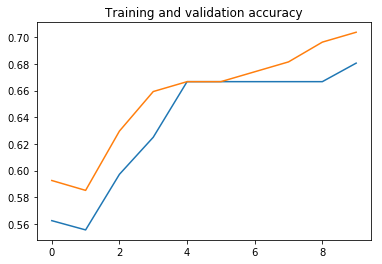

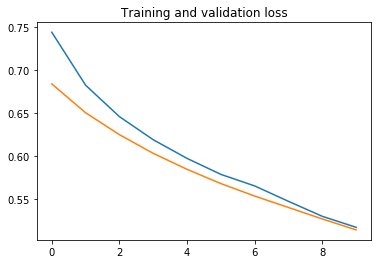

In [18]:
#Plot training and validation accuracy per epoch

plot_loss_acc(history)